In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
slice_df = pd.read_csv('../beast_results/MERGE_SLICE_DFS/slice_df.csv.gz', compression='gzip')
slice_df['tree_idx'] = slice_df['tree_idx'].astype(int)

In [4]:
slice_df

,uid,tree_idx,entry_idx,time,delta_expr,delta_bind_CGG
0,D15_M6_GC11,500,0,0,0.00000,0.00000
1,D15_M6_GC11,500,0,1,0.00000,0.00000
2,D15_M6_GC11,500,1,1,0.00000,0.00000
3,D15_M6_GC11,500,0,2,0.00000,0.00000
4,D15_M6_GC11,500,1,2,0.00000,0.00000
...,...,...,...,...,...,...
120713809,D20_M22_GC88,2499,77,19,-0.92755,-2.18001
120713810,D20_M22_GC88,2499,78,19,0.04300,-0.26491
120713811,D20_M22_GC88,2499,79,19,0.12209,-0.11339
120713812,D20_M22_GC88,2499,80,19,-0.01097,-1.05394


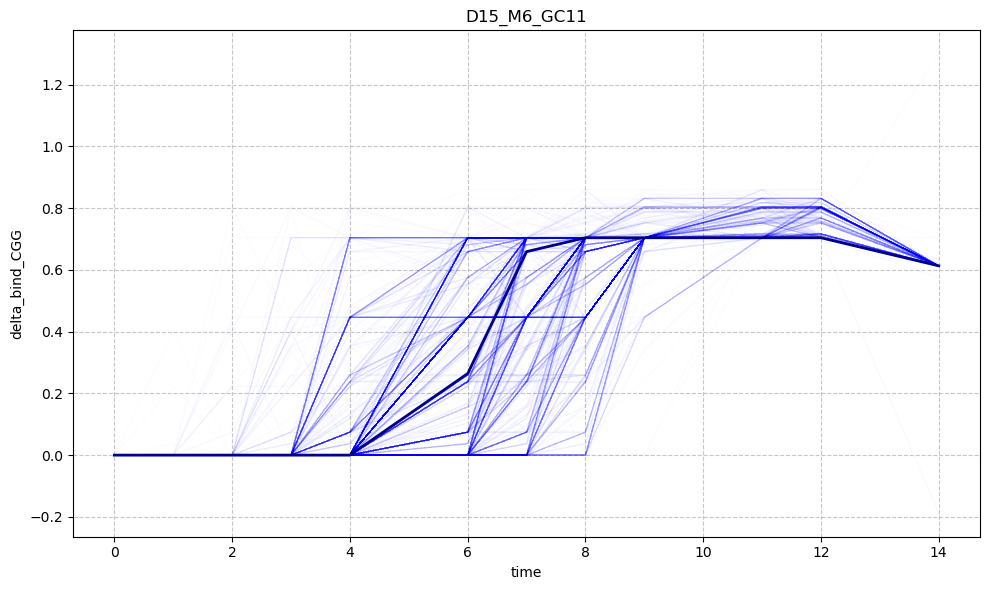

In [7]:
df = slice_df.copy()

first_uid = df['uid'].iloc[0]
first_uid_data = df[df['uid'] == first_uid]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Get unique tree_idx values
unique_trees = first_uid_data['tree_idx'].unique()

# Plot one light line per tree_idx
for tree_idx in unique_trees:
    tree_data = first_uid_data[first_uid_data['tree_idx'] == tree_idx]
    tree_data_grouped = tree_data.groupby('time')['delta_bind_CGG'].median().reset_index()
    ax.plot(tree_data_grouped['time'], tree_data_grouped['delta_bind_CGG'], 
            alpha=0.01, linewidth=1, color='blue')

# Add a thicker line for the mean across all tree_idx values, if desired
grouped = first_uid_data.groupby('time')['delta_bind_CGG'].median().reset_index()
ax.plot(grouped['time'], grouped['delta_bind_CGG'], 
        color='darkblue', linewidth=2, linestyle='-')

# Set labels and title
ax.set_xlabel('time')
ax.set_ylabel('delta_bind_CGG')
ax.set_title(f'{first_uid}')

# Add grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Ensure tight layout
plt.tight_layout()

# Show the plot
plt.show()

In [11]:
# print out delta_bind_CGG for first_uid_data restricted to age == 20, 
# JG - I assume now you want the time == 0 for the naive
first_uid_data[ first_uid_data['time'] == 0 ][['delta_bind_CGG', 'tree_idx']]

,delta_bind_CGG,tree_idx
0,0.0,500
653,0.0,501
1194,0.0,502
1785,0.0,503
2434,0.0,504
...,...,...
1196247,0.0,2495
1196796,0.0,2496
1197377,0.0,2497
1197889,0.0,2498


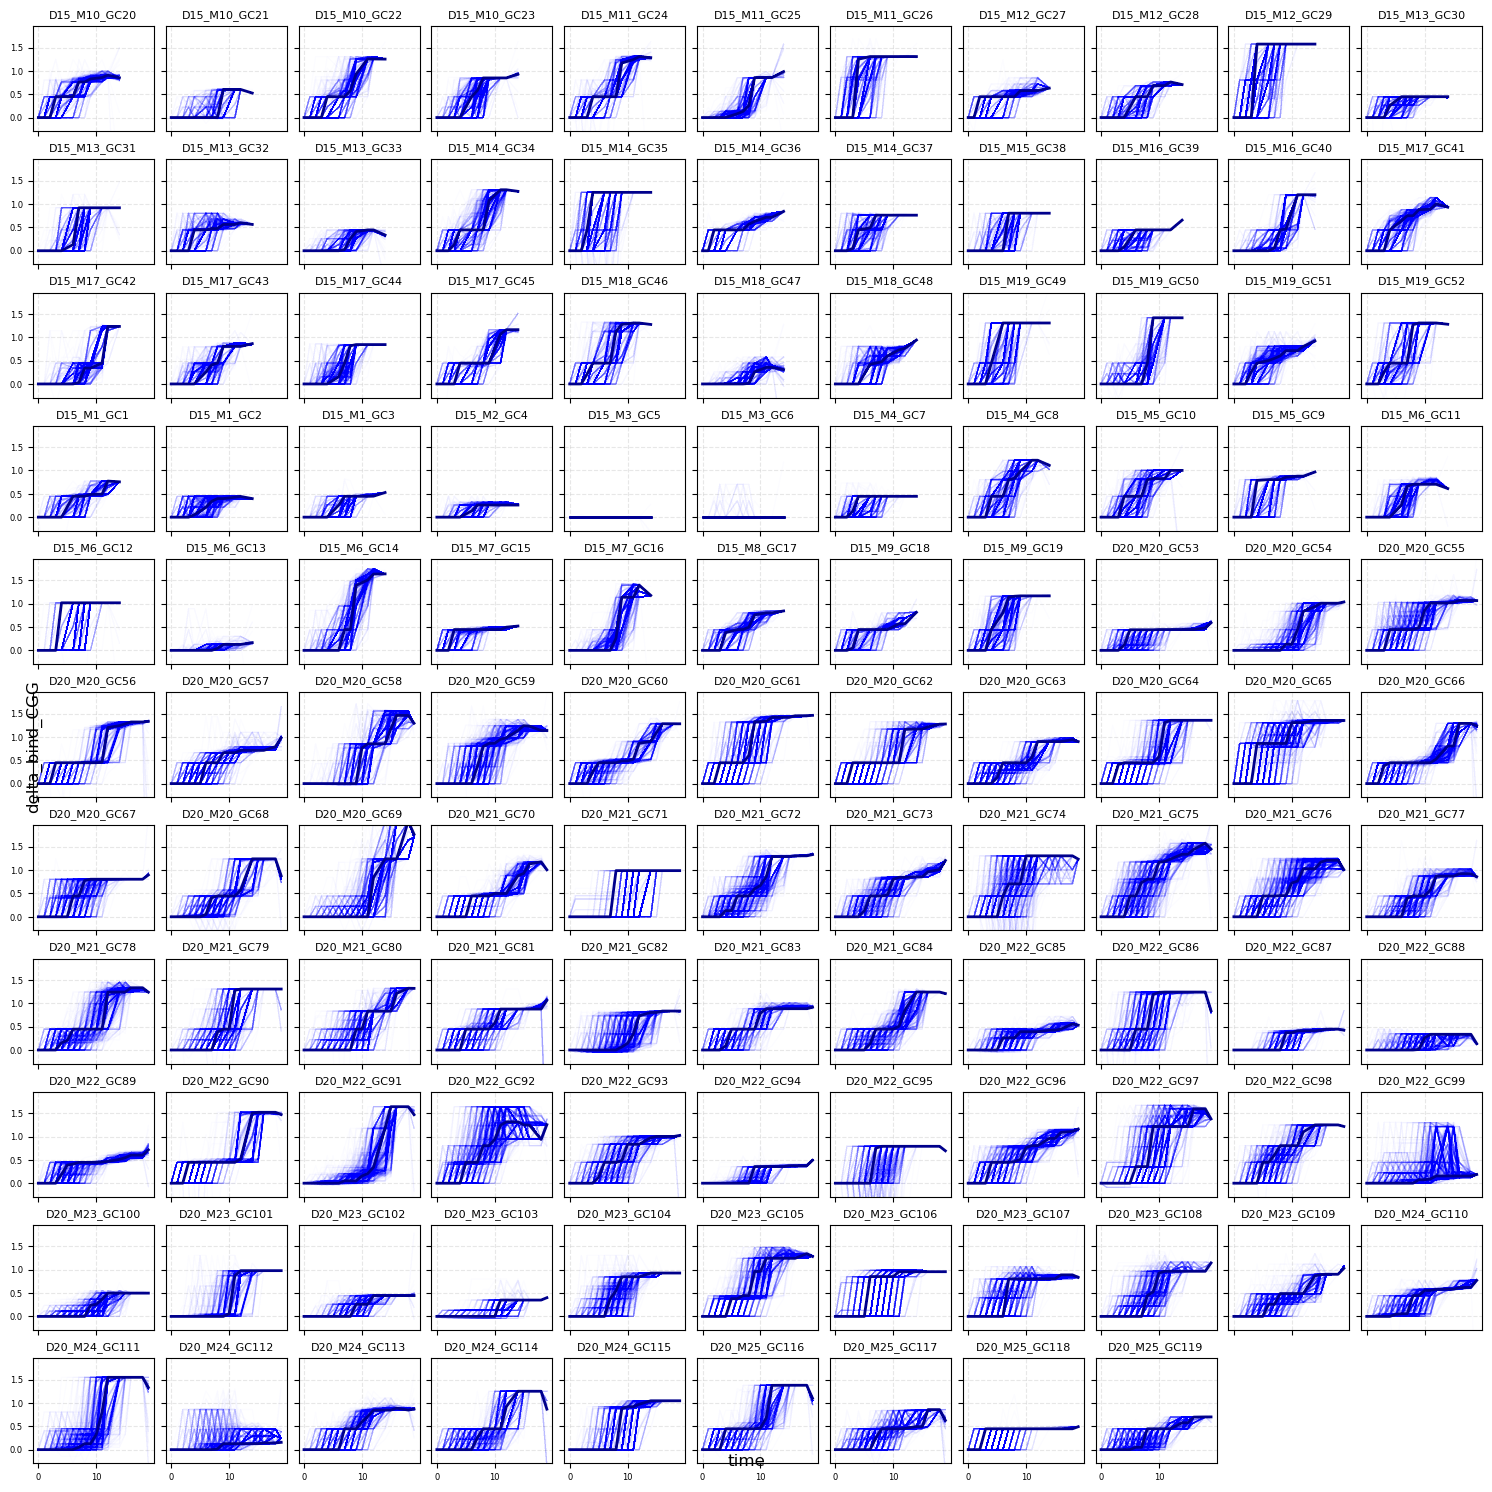

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec

def plot_single_uid(ax, uid_data, uid, y_range):
    """Plot a single UID panel with individual tree_idx lines and median.
    
    Args:
        ax: The matplotlib axis to plot on.
        uid_data: DataFrame filtered for a specific UID.
        uid: The UID string for the title.
        y_range: Tuple of (min, max) for the y-axis limits.
    """
    # Get unique tree_idx values
    unique_trees = uid_data['tree_idx'].unique()
    
    # Plot one light line per tree_idx
    for tree_idx in unique_trees:
        tree_data = uid_data[uid_data['tree_idx'] == tree_idx]
        # Group by time and calculate me
        tree_data_grouped = tree_data.groupby('time')['delta_bind_CGG'].median().reset_index()
        # Plot the median line for this tree_idx
        ax.plot(tree_data_grouped['time'], tree_data_grouped['delta_bind_CGG'],
                alpha=0.01, linewidth=1, color='blue')
        
    # Add a thicker line for the median across all tree_idx values
    grouped = uid_data.groupby('time')['delta_bind_CGG'].median().reset_index()
    ax.plot(grouped['time'], grouped['delta_bind_CGG'], 
            color='darkblue', linewidth=2, linestyle='-')
    
    # Set title and y-range
    ax.set_title(uid, fontsize=8)
    ax.set_ylim(y_range)
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.3)

# Main plotting function
def plot_all_uids(df):
    # Get all unique UIDs
    unique_uids = sorted(df['uid'].unique())
    n_uids = len(unique_uids)
    
    # Calculate the 95% range of delta_bind_CGG for consistent y-axis
    lower_bound = np.percentile(df['delta_bind_CGG'], 2.5)
    upper_bound = np.percentile(df['delta_bind_CGG'], 97.5)
    y_range = (lower_bound, upper_bound)
    
    # Calculate grid dimensions
    n_cols = int(np.ceil(np.sqrt(n_uids)))
    n_rows = int(np.ceil(n_uids / n_cols))
    
    # Create figure with GridSpec for better control
    fig = plt.figure(figsize=(15, 15))
    gs = GridSpec(n_rows, n_cols, figure=fig)
    
    # Create all subplots
    for i, uid in enumerate(unique_uids):
        row = i // n_cols
        col = i % n_cols
        
        # Create subplot with shared x and y axes
        if i == 0:
            ax = fig.add_subplot(gs[row, col])
            first_ax = ax
        else:
            ax = fig.add_subplot(gs[row, col], sharex=first_ax, sharey=first_ax)
        
        # Filter data for this UID
        uid_data = df[df['uid'] == uid]
        
        # Plot data for this UID
        plot_single_uid(ax, uid_data, uid, y_range)
        
        # Only show x and y labels for the outer subplots
        if row != n_rows - 1:
            ax.set_xlabel('')
            plt.setp(ax.get_xticklabels(), visible=False)
        if col != 0:
            ax.set_ylabel('')
            plt.setp(ax.get_yticklabels(), visible=False)
        
        # Make tick labels smaller
        ax.tick_params(axis='both', which='major', labelsize=6)
    
    # Add overall labels
    fig.text(0.5, 0.02, 'time', ha='center', fontsize=12)
    fig.text(0.02, 0.5, 'delta_bind_CGG', va='center', rotation='vertical', fontsize=12)
    
    # Tight layout with padding
    plt.tight_layout(pad=1.0, h_pad=0.5, w_pad=0.5)
    
    return fig

# Call the function to create the plot
fig = plot_all_uids(df)
plt.show()